In [1]:
from models.classical_model import ClassicDetector
from ultralytics import YOLO
import numpy as np
import os
import cv2
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

In [2]:
classical_model = ClassicDetector('training/svm_sstw/scaler.onnx', 'training/svm_sstw/ovr_linear_svc.onnx')
yolo_fp32 = YOLO('training/yolo_sstw/weights/best-fp32.onnx', task='detect')
yolo_fp16 = YOLO('training/yolo_sstw/weights/best-fp16.onnx', task='detect')

In [4]:
image_test, label_test = [], []
final_label_test = []

YOLO_DATA_PATH = 'a9_dataset/yolo_data/test'

for image_name, label_name in zip(os.listdir(os.path.join(YOLO_DATA_PATH, 'images')), os.listdir(os.path.join(YOLO_DATA_PATH, 'labels'))):
  image_test.append(cv2.imread(os.path.join(YOLO_DATA_PATH, 'images', image_name)))
  label_test.append(np.loadtxt(os.path.join(YOLO_DATA_PATH, 'labels', label_name)))
  
image_test = image_test[:30]
label_test = label_test[:30]

In [4]:
formatted_true_test = []

for i, label in enumerate(label_test):
  img_h, img_w = image_test[i].shape[:2]
  
  if len(label) == 0:
    formatted_true_test.append({
        'boxes': torch.tensor([], dtype=torch.float32),
        'labels': torch.tensor([], dtype=torch.int64)
    })
    continue

  if label.ndim == 1: label = label[None, :]
  
  cls_id = label[:, 0]
  x_c = label[:, 1]
  y_c = label[:, 2]
  w   = label[:, 3]
  h   = label[:, 4]
  
  x_min = (x_c - w / 2) * img_w
  y_min = (y_c - h / 2) * img_h
  x_max = (x_c + w / 2) * img_w
  y_max = (y_c + h / 2) * img_h
  
  boxes = np.stack([x_min, y_min, x_max, y_max], axis=1)
  
  formatted_true_test.append({
    'boxes': torch.tensor(boxes, dtype=torch.float32),
    'labels': torch.tensor(cls_id, dtype=torch.int64),
  })

In [5]:
classical_detections = []
yolo_fp16_detections = []
yolo_fp32_detections = []

In [6]:
def convert_detections(preds, is_yolo: bool):
  formatted_preds = []
  
  if is_yolo:
    for p in preds:
      formatted_preds.append({
          'boxes': p.boxes.xyxy.cpu(),
          'scores': p.boxes.conf.cpu(),
          'labels': p.boxes.cls.cpu().int()
      })
  else:
    for p in preds:
      if len(p.boxes) == 0:
        formatted_preds.append({
          'boxes': torch.tensor([], dtype=torch.float32),
          'scores': torch.tensor([], dtype=torch.float32),
          'labels': torch.tensor([], dtype=torch.int64)
        })
        continue
      
      boxes_list = []
      scores_list = []
      labels_list = []
      
      for box in p.boxes:
        boxes_list.append(box.xyxy[0])
        scores_list.append(box.conf[0])
        labels_list.append(box.cls[0])
      
      formatted_preds.append({
        'boxes': torch.tensor(np.array(boxes_list), dtype=torch.float32),
        'scores': torch.tensor(np.array(scores_list), dtype=torch.float32),
        'labels': torch.tensor(np.array(labels_list), dtype=torch.int64)
      })
  
  return formatted_preds

In [11]:
iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
classic_mAP = MeanAveragePrecision(iou_thresholds=iou_thresholds)
yolo_fp16_mAP = MeanAveragePrecision(iou_thresholds=iou_thresholds)
yolo_fp32_mAP = MeanAveragePrecision(iou_thresholds=iou_thresholds)

# classical_detections = classical_model(image_test)
fp16_detections = []
for img in image_test:
  fp16_detections.append(yolo_fp16(img, imgsz=640, verbose=False)[0])

fp32_detections = []
for img in image_test:
  fp32_detections.append(yolo_fp32(img, imgsz=640, verbose=False)[0])

formatted_classical_detections = convert_detections(classical_detections, False)
formatted_fp16_detections = convert_detections(fp16_detections, True)
formatted_fp32_detections = convert_detections(fp32_detections, True)

classic_mAP.update(formatted_classical_detections, formatted_true_test)
yolo_fp16_mAP.update(formatted_fp16_detections, formatted_true_test)
yolo_fp32_mAP.update(formatted_fp32_detections, formatted_true_test)

In [14]:
print("Classical mAP:", classic_mAP.compute())
print("YOLO FP16 mAP:", yolo_fp16_mAP.compute())
print("YOLO FP32 mAP:", yolo_fp32_mAP.compute())

Classical mAP: {'map': tensor(0.0077), 'map_50': tensor(0.0160), 'map_75': tensor(0.0060), 'map_small': tensor(0.0035), 'map_medium': tensor(0.0155), 'map_large': tensor(0.1158), 'mar_1': tensor(0.0123), 'mar_10': tensor(0.0293), 'mar_100': tensor(0.0311), 'mar_small': tensor(0.0126), 'mar_medium': tensor(0.0544), 'mar_large': tensor(0.1667), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)}
YOLO FP16 mAP: {'map': tensor(0.7615), 'map_50': tensor(0.8368), 'map_75': tensor(0.8109), 'map_small': tensor(0.6784), 'map_medium': tensor(0.9294), 'map_large': tensor(1.), 'mar_1': tensor(0.2831), 'mar_10': tensor(0.6868), 'mar_100': tensor(0.7740), 'mar_small': tensor(0.6974), 'mar_medium': tensor(0.9365), 'mar_large': tensor(1.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)}
YOLO FP32 mAP: {'map': tensor(0.7609), 'map_50': tensor(0.8368), 'map_75':

In [ ]:
yolo_model = YOLO('training/yolo_sstw/weights/best.pt')
yolo_model.cpu()

target_layers = [yolo_model.model.model[-4]]

yolo_cam = EigenCAM(yolo_model, target_layers, task='od')

In [105]:
index = np.random.randint(0, 30)
img = image_test[index]


0: 640x640 9 Trucks, 7 Cars, 9 Vans, 9 Trailers, 90.4ms
Speed: 2.4ms preprocess, 90.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


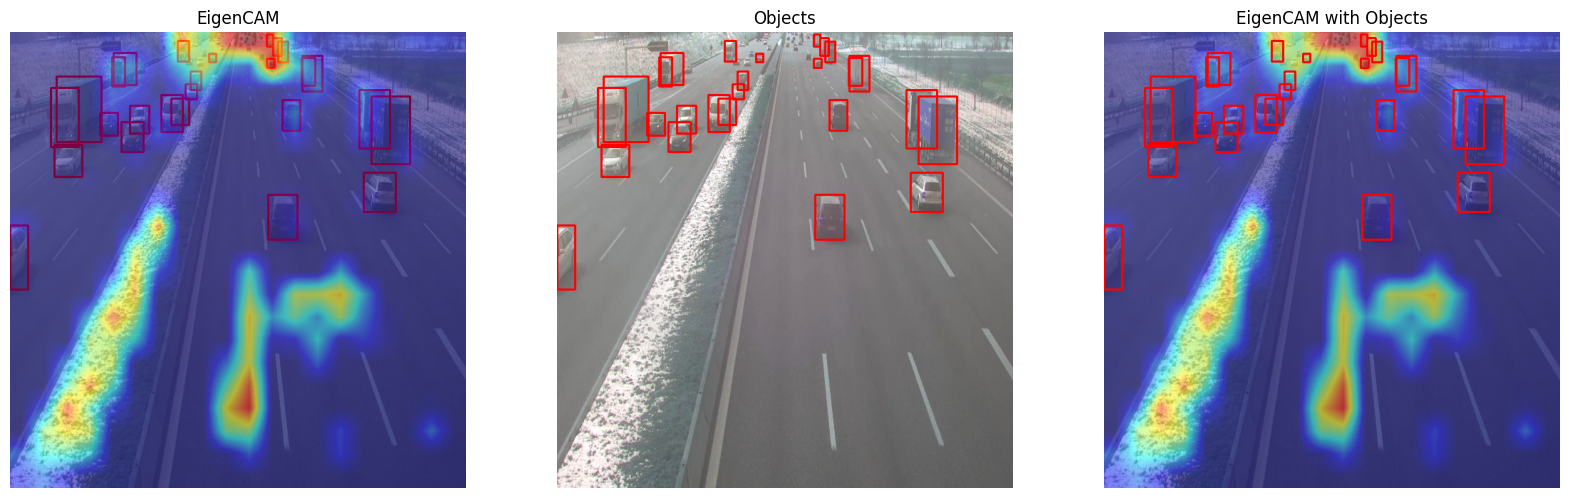

In [108]:
grayscale_cam = yolo_cam(img)[0, :, :]
cam_image = show_cam_on_image(img / 255., grayscale_cam, use_rgb=True)

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.title('EigenCAM')
plt.imshow(cam_image)
plt.axis('off')

for x1, y1, x2, y2 in formatted_true_test[index]['boxes']:
  cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
  cv2.rectangle(cam_image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

plt.subplot(1, 3, 2)
plt.title('Objects')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('EigenCAM with Objects')
plt.imshow(cam_image)
plt.axis('off')

plt.show()

593

In [ ]:
import multiprocessing
import time
from ultralytics import YOLO
import traceback

# --- 1. Define the Worker Function ---
# This runs completely isolated in its own memory space
def detect_worker(model_path, model_type, shared_fps_counter, duration):
  import cv2 
  
  try:
    frames = []

    for image_name in os.listdir(os.path.join('a9_dataset/yolo_data/test', 'images')):
      frames.append(cv2.imread(os.path.join('a9_dataset/yolo_data/test', 'images', image_name)))
    
    # A. Load Model INSIDE the process
    if model_type == 'yolo':
      model = YOLO(model_path)
      def run_inference(frame):
        model(frame, verbose=False)
            
    elif model_type == 'classical':
      from models.classical_model import ClassicDetector
      model = ClassicDetector('training/svm_sstw/scaler.onnx', 'training/svm_sstw/ovr_linear_svc.onnx')

      def run_inference(frame):
        model.predict(frame)

    # B. Run Inference Loop
    start_time = time.time()
    while True:
      if time.time() - start_time > duration:
        break
      
      for frame in frames:
        run_inference(frame)
      
        with shared_fps_counter.get_lock():
          shared_fps_counter.value += 1
  except Exception:
    traceback.print_exc()

# --- 2. The Runner Function ---
def run_benchmark(label, model_path, model_type, timeout=10):
    shared_fps = multiprocessing.Value('i', 0)
    
    p = multiprocessing.Process(target=detect_worker, 
                                args=(model_path, model_type, shared_fps, timeout))
    p.start()
    
    print(f"[{label}] Benchmarking for {timeout} seconds...")
    p.join(timeout)

    if p.is_alive():
        p.terminate()
        p.join()
    
    final_fps = shared_fps.value / timeout
    print(f"✅ {label} Finished. Average FPS: {final_fps:.2f}")
    return final_fps

# --- 3. Main Execution ---
if __name__ == '__main__':
    yolo_fp16_path = 'training/yolo_sstw/weights/best-fp16.onnx'
    yolo_fp32_path = 'training/yolo_sstw/weights/best-fp32.onnx'

    # Run
    fps16 = run_benchmark("YOLO FP16", yolo_fp16_path, 'yolo', timeout=10)
    fps32 = run_benchmark("YOLO FP32", yolo_fp32_path, 'yolo', timeout=10)
    fps_cl = run_benchmark("Classical", '', 'classical', timeout=10)
    
    # Comparison
    print(f"\n--- Final Results ---")
    print(f"YOLO FP16: {fps16:.2f}")
    print(f"Classical: {fps_cl:.2f}")

[YOLO FP16] Benchmarking for 10 seconds...
✅ YOLO FP16 Finished. Average FPS: 0.00
[YOLO FP32] Benchmarking for 10 seconds...
✅ YOLO FP32 Finished. Average FPS: 0.00
[Classical] Benchmarking for 10 seconds...
✅ Classical Finished. Average FPS: 0.00

--- Final Results ---
YOLO FP16: 0.00
Classical: 0.00


In [7]:
yolo16_fps

0